<a href="https://colab.research.google.com/github/neworldemancer/DSF5/blob/master/Course_3_venice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to machine learning & Data Analysis

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Data Science Lab, University Of Bern, 2023

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Part 1.

In [3]:
!pip install scipy

In [4]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


In [5]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.mixture import GaussianMixture

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from matplotlib import  pyplot as plt
import numpy as np
import pandas as pd
from imageio import imread
from time import time as timer
import os
import tarfile

import tensorflow as tf

%matplotlib inline
import umap
from matplotlib import animation
from IPython.display import HTML

from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler

In [6]:
if not os.path.exists('data'):
    path = os.path.abspath('.')+'/colab_material.tgz'
    tf.keras.utils.get_file(path, 'https://github.com/neworldemancer/DSF5/raw/master/colab_material.tgz')
    tar = tarfile.open(path, "r:gz")
    tar.extractall()
    tar.close()

In [7]:
from utils.routines import *

In [8]:
def house_prices_dataset(return_df=False, price_max=400000, area_max=40000):
  path = 'data/AmesHousing.csv'

  df = pd.read_csv(path, na_values=('NaN', ''), keep_default_na=False)

  rename_dict = {k:k.replace(' ', '').replace('/', '') for k in df.keys()}
  df.rename(columns=rename_dict, inplace=True)

  useful_fields = ['LotArea',
                  'Utilities', 'OverallQual', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                  'HeatingQC', 'CentralAir', 'Electrical',
                  '1stFlrSF', '2ndFlrSF','GrLivArea',
                  'FullBath', 'HalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                  'Functional','PoolArea',
                  'YrSold', 'MoSold'
                  ]
  target_field = 'SalePrice'

  df.dropna(axis=0, subset=useful_fields+[target_field], inplace=True)

  cleanup_nums = {'Street':      {'Grvl': 0, 'Pave': 1},
                  'LotFrontage': {'NA':0},
                  'Alley':       {'NA':0, 'Grvl': 1, 'Pave': 2},
                  'LotShape':    {'IR3':0, 'IR2': 1, 'IR1': 2, 'Reg':3},
                  'Utilities':   {'ELO':0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3},
                  'LandSlope':   {'Sev':0, 'Mod': 1, 'Gtl': 3},
                  'ExterQual':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'ExterCond':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'BsmtQual':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtCond':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtExposure':{'NA':0, 'No':1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                  'BsmtFinType1':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'BsmtFinType2':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'HeatingQC':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'CentralAir':  {'N':0, 'Y': 1},
                  'Electrical':  {'':0, 'NA':0, 'Mix':1, 'FuseP':2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5},
                  'KitchenQual': {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Functional':  {'Sal':0, 'Sev':1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2':5, 'Min1':6, 'Typ':7},
                  'FireplaceQu': {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'PoolQC':      {'NA':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Fence':       {'NA':0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv':4},
                  }

  df_X = df[useful_fields].copy()
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical
  df_Y = df[target_field].copy()

  x = df_X.to_numpy().astype(np.float32)
  y = df_Y.to_numpy().astype(np.float32)

  if price_max>0:
    idxs = y<price_max
    x = x[idxs]
    y = y[idxs]

  if area_max>0:
    idxs = x[:,0]<area_max
    x = x[idxs]
    y = y[idxs]

  return (x, y, df) if return_df else (x,y)


def house_prices_dataset_normed():
    x, y = house_prices_dataset(return_df=False, price_max=-1, area_max=-1)

    scaler=StandardScaler()
    features_scaled=scaler.fit_transform(x)

    return features_scaled

**CLUSTERING Objective:** 

Clustering techniques divide the set of data into group of points having common features. Each data point $p$ gets assigned a label $l_p \in \{1,..,K\}$ representing the group to which it belongs. In this presentation the data points are supposed to have $D$ features.

**General Caveat:** 

Clustering techniques rely on a a-priori fixed notion of 'distance' between the points. This implies:

- The default distance is called `euclidean`: $d(x_p,x_{q})=\sqrt{\sum_{i} |x_{p,i}-x_{q,i}|^{2}}$. This distance is not invariant if we change units, if all features have difference units. One way to keep on using the default euclidean distance is normalizing variables.

- Other ad-hoc distance may be defined depending on the use-case scenario.

- Results of clustering must always be checked by experts of the field of interest. Clustering is an iterative process.

Note that if your data is labelled (e.g. each label is assigned to a class), the number of groups can be different than the number of classes. 

# 1. Non-linear dimensionality reduction

- Non-linear dimensionality reduction techniques can be used to map the original set of points with $D$ features into 2 features.

- PCA also offers such a mapping (take the first two relevant scores) but in general two components are not enough to conserve the variance. This happens because PCA limits itself to new features that are `linear combinations` of the old one

- Non-linear dimensionality reduction techniques do not pose themselves such a constraint and therefore can map data into very low dimensions (for example 2)

- If we have a map in 2D we can visualize clusters by eye

`t-Sne` and `UMAP` are the two most popular dimensionality reduction techniques. They differ in the type of information that is preserved before and after the mapping.

- `t-Sne` uses a `statistical description` of the environment of a sample point ;
- `UMAP` conserves the `connectivity` (topological) properties of the environment of a sample point ;

The projection on the low-dimensional space is optimized in order to match as much as possible the description of the local environment.

It is not the goal of this introduction to discuss the derivation of such approaches, which can be found in the references:

https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf

https://arxiv.org/pdf/1802.03426.pdf

Results between UMAP and t-Sne shoud be comparable.

In [32]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

n_examples = 5000
data=train_images[:n_examples,:].reshape(n_examples,-1)
data=data/255

labels=train_labels[:n_examples]

In [ ]:
# not to run on COLAB

# tsne_model = TSNE(perplexity=10, n_components=2, learning_rate=200,
#                   early_exaggeration=4.0,init='pca',
#                   n_iter=2000, random_state=2233212,
#                   metric='euclidean', verbose=100, n_jobs=1)

# tsne_mnist = tsne_model.fit_transform(data)

# plt.scatter(tsne_mnist[:,0],tsne_mnist[:,1],c=labels,s=10)
# plt.show()

 | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/t_sne_mnist.png" width="100%"/> | <img src="https://github.com/neworldemancer/DSF5/raw/master/figures/mnist.png" width="100%"/> |
 |  -----:| -----:|

In [23]:
from mpl_toolkits import mplot3d

/Users/srime/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


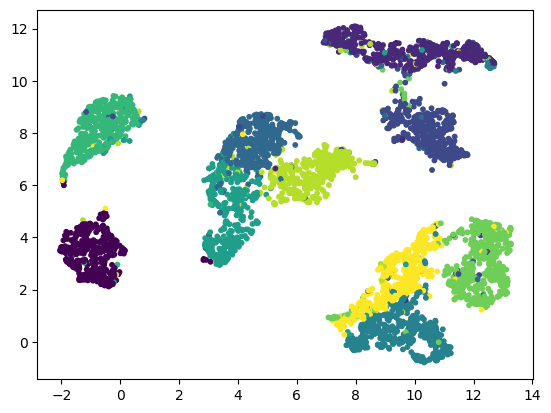

/Users/srime/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


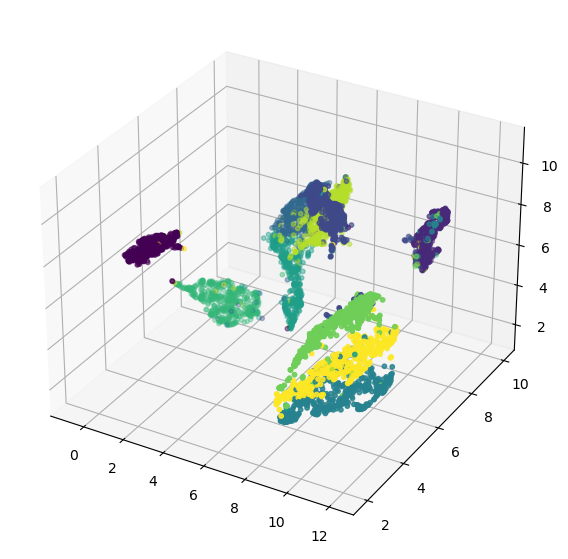

In [34]:
umap_model = umap.UMAP(n_neighbors=10, n_components=2, random_state=1711)
umap_mnist = umap_model.fit_transform(data)

plt.scatter(umap_mnist[:,0],umap_mnist[:,1],c=labels,s=10)
plt.show()

umap_model = umap.UMAP(n_neighbors=10, n_components=3, random_state=1711)
umap_mnist = umap_model.fit_transform(data)

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(umap_mnist[:, 0], umap_mnist[:, 1],umap_mnist[:, 2], c=labels, s=10)
plt.show()

In [35]:
data=house_prices_dataset_normed()

/Users/srime/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


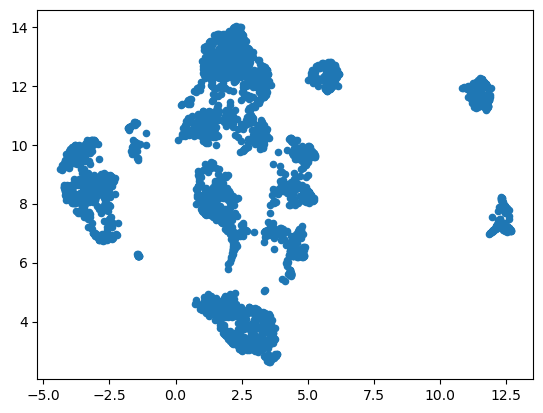

In [75]:
umap_model = umap.UMAP(n_neighbors=30, n_components=2, random_state=1711)
umap_houses = umap_model.fit_transform(data)
plt.scatter(umap_houses[:, 0], umap_houses[:, 1], s=20)
plt.show()

/Users/srime/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


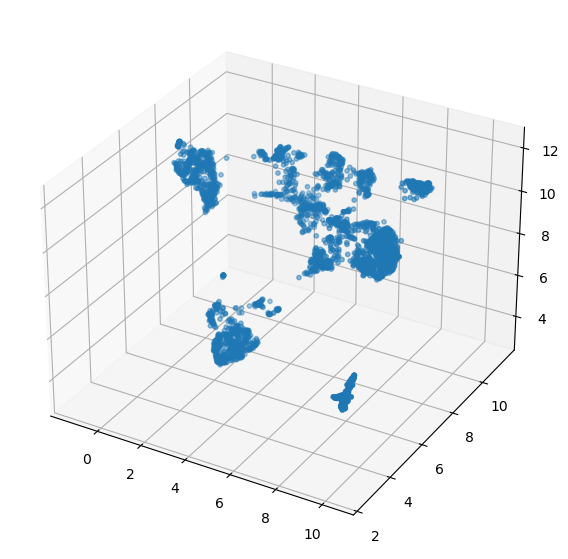

In [37]:
umap_model = umap.UMAP(n_neighbors=30, n_components=3, random_state=1711)
umap_houses = umap_model.fit_transform(data)

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

ax.scatter3D(umap_houses[:, 0], umap_houses[:, 1],umap_houses[:, 2], s=10)
plt.show()

## 2. K-Means

Consider first that you know the number of groups over which you want to divide your data. For example $K=3$ or $K=10$ groups. 

***-cluster centers***

K-means heavily relies on the concept of:

`cluster centers`. Each group gets assigned a cluster center, as a mean representative point. The centroids given by the expression:
$$\mathbf{c}_k=\frac{1}{N_k}\sum_{p \in S_k} \mathbf{x_p}$$

, $S_k$ is the subset of points assigned to the same group $k$ and $N_k$ is the number of points in $S_k$.

If the data cloud is made of images, it is the image containing at each pixel the mean value of all images of that group. 

If the data cloud is made of questionnaires, it is the mean value assigned to an answer by all questionnaires belonging to that group.

If the data cloud is made of pressure sensors, it assigns to each sensors the mean of the pressure over all time spans belonging to that group, and so on...

$K-Means$ assign cluster center to a single group. All points whose closest cluster center belongs to class $K$, is assigned to group $K$ as well.


***-loss function***

The cluster centres are chosen in order to minimize the following loss function:

$$\sum_{k \in \text{classes}} \sum_{p \in S_k} d(\mathbf{x}_p,\mathbf{c}_{k})^2$$

where $S_k$ is the subset of points assigned to the same group $k$.

d is the metric function suited of the problem of interest. Here we use the Euclidean distance as a metric :

$$d(\mathbf{x}_p,\mathbf{c}_{k})=|\mathbf{x}_p-\mathbf{c}_{k}| \quad \quad $$


Such an algorithm finds local minima and may need to be started several times with different initializations.

**-vary the number of classes and validate the clustering**

*Silhouette score*: K-means clustering fixes the number of clusters a priori. Some technique must be chosen to score the different optimal clusterings for different $k$. One technique chooses the best *Silouhette score*. Intuitively, this evaluates the typical distance of points within a same clusters and compares it against the typical distance of points belonging to neighboring but different clusters ( https://en.wikipedia.org/wiki/Silhouette_(clustering) ).


### Sklearn: implementation and usage of K-means.

We start with a 2D example that can be visualized.

First we load the data-set.

In [38]:
points=km_load_th1()

Explore the data-set checking the dataset dimensionality.

In [39]:
print(points.shape)
print('We have ', points.shape[0], 'points with two features')

(120, 2)
We have  120 points with two features


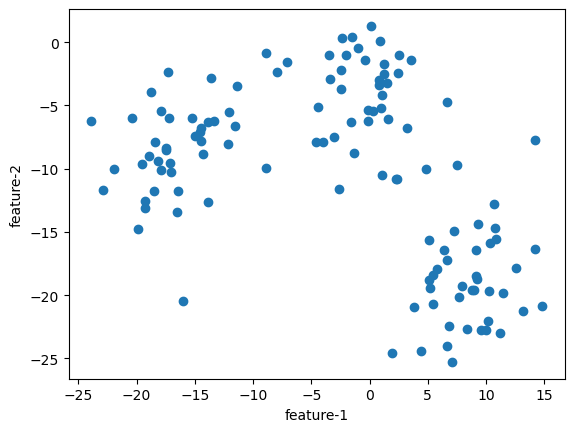

In [40]:
plt.plot(points[:,0],points[:,1],'o')
plt.xlabel('feature-1')
plt.ylabel('feature-2')
plt.show()

It looks visually that the data set has three clusters. We will cluster them using K-means. As usual, we create a KMeans object. Note that we do not need to initialize it with a data-set.

In [84]:
clusterer = KMeans(n_clusters=10, random_state=10)

A call to the fit method computes the cluster centers which can be plotted alongside the data-set. They are accessible from the cluster_centers_ attribute:

/Users/srime/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


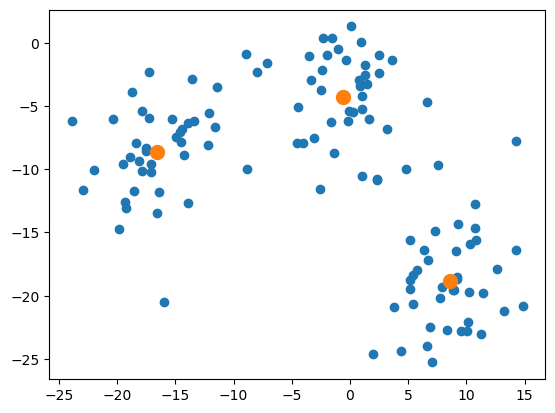

In [42]:
clusterer.fit(points)
plt.plot(points[:,0],points[:,1],'o')
plt.plot(clusterer.cluster_centers_[:,0],clusterer.cluster_centers_[:,1],'o',markersize=10)
plt.show()

In [43]:
clusterer.cluster_centers_[:,:]

array([[  8.5901409 , -18.82448838],
       [-16.59659661,  -8.6652939 ],
       [ -0.62089021,  -4.27748903]])

The predict method assigns a new point to the nearest cluster. We can use predict with the training dataset and color the data-set according to the cluster label.

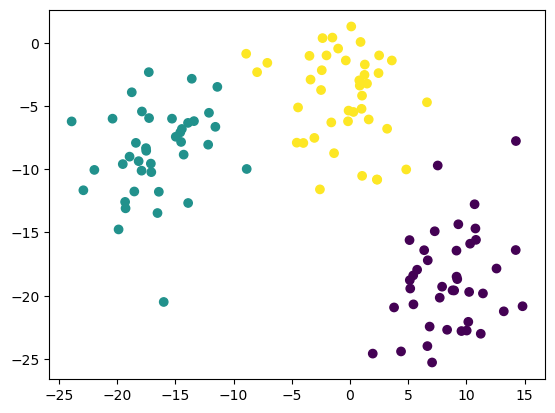

In [44]:
cluster_labels=clusterer.predict(points)
plt.scatter(points[:,0],points[:,1],c=cluster_labels)
plt.show()

Finally, we can try to vary the number of clusters and score them with the Silhouette score.

/Users/srime/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


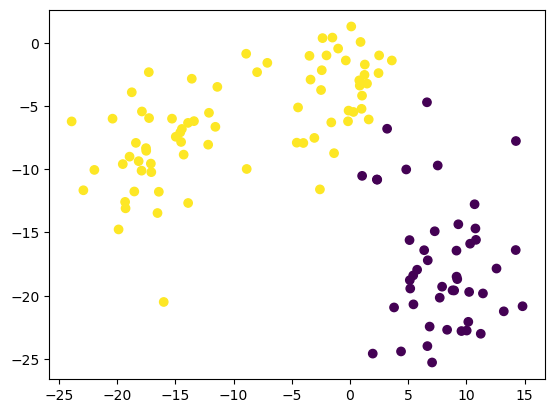

/Users/srime/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


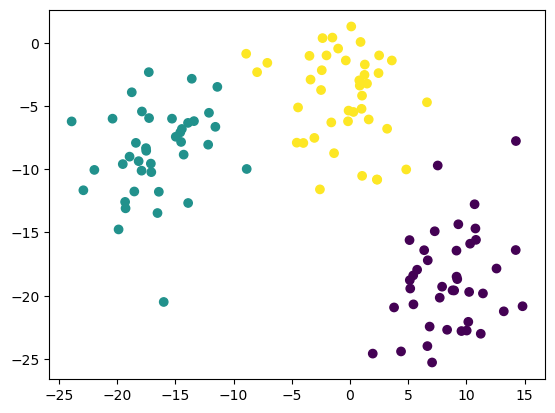

/Users/srime/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


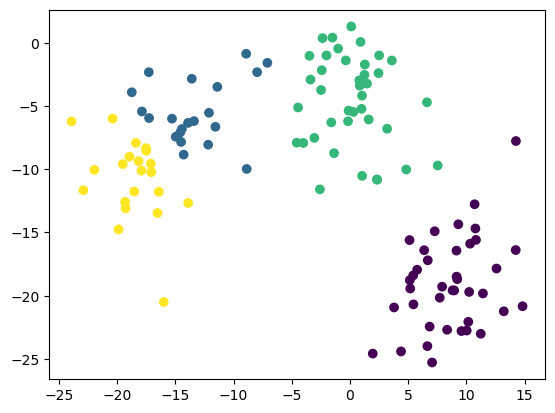

/Users/srime/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


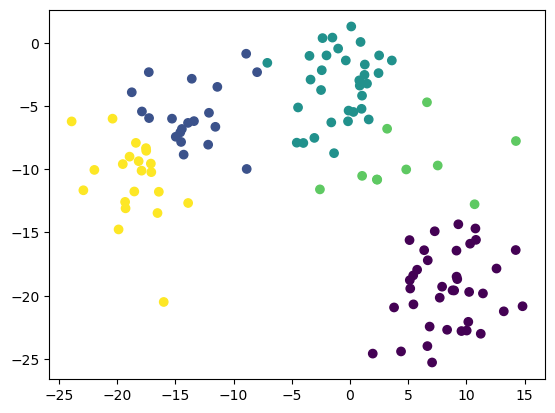

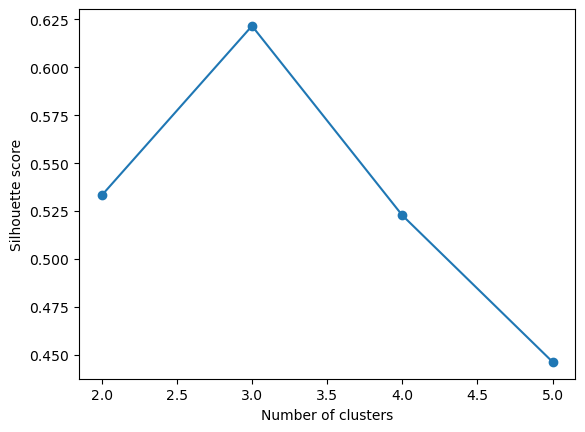

In [56]:
sil=[]

for iclust in range(2,6):
    clusterer = KMeans(n_clusters=iclust, random_state=10)
    cluster_labels = clusterer.fit_predict(points)
    score=silhouette_score(points,cluster_labels)
    sil.append(score)
    plt.scatter(points[:,0],points[:,1],c=cluster_labels)
    plt.show()
    
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.plot(np.arange(len(sil))+2, sil,'-o')
plt.show()

The same techniques can be used on high dimensional data-sets. We use here the famous MNIST dataset for integer digits, that we are downloading from tensorflow.

In [57]:
fmnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fmnist.load_data()

X=train_images[:5000,:].reshape(5000,-1)

(5000, 784)


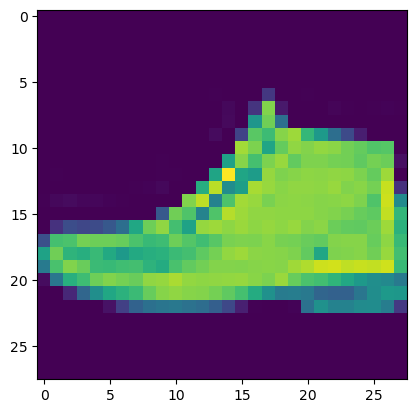

In [58]:
print(X.shape)
image=X[1232,:].reshape(28,28)
plt.imshow(image)

We can cluster the images exactly as we did for the 2d dataset.

In [71]:
clusterer = KMeans(n_clusters=10, random_state=10)
cluster_labels = clusterer.fit_predict(X)

/Users/srime/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


We can plot the cluster centers (which are 2D figures!) to see if the clustering is learning correct patterns! 

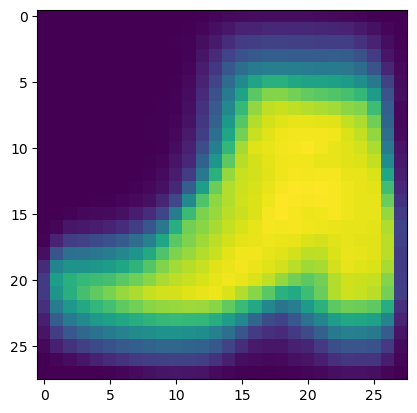

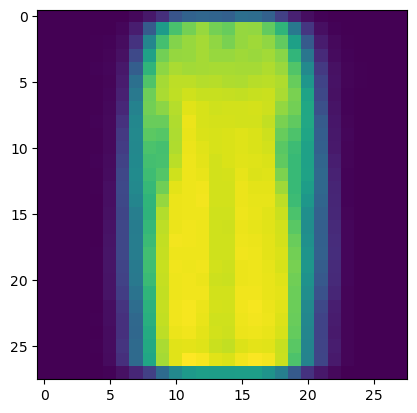

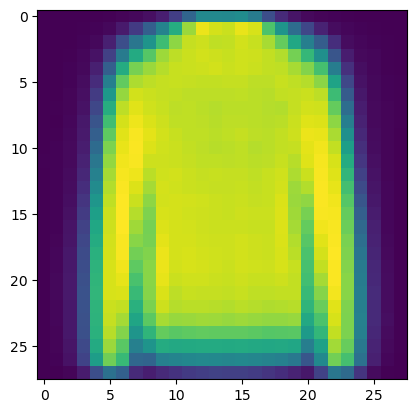

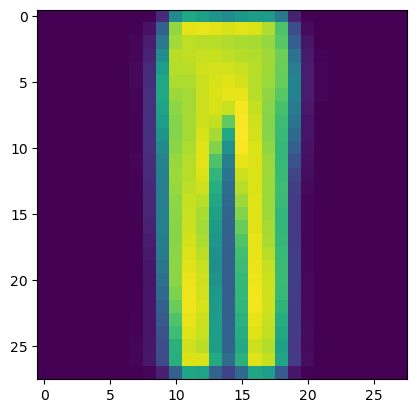

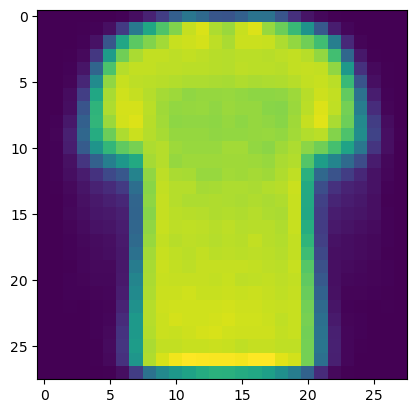

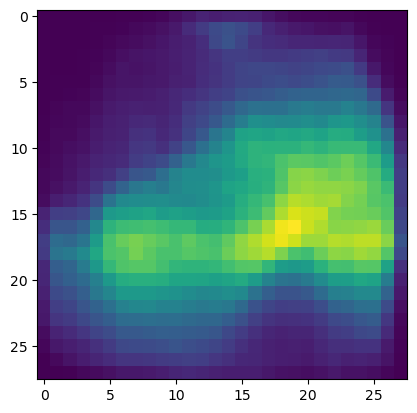

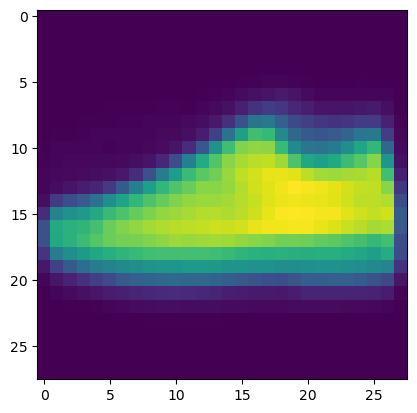

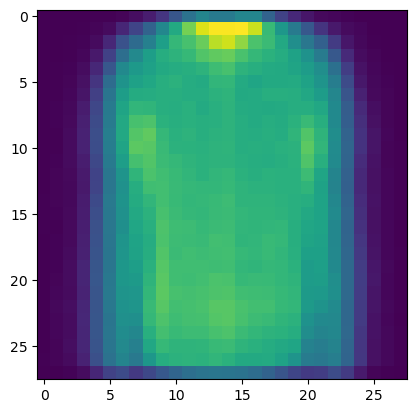

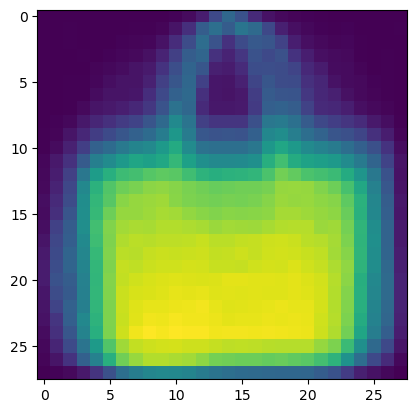

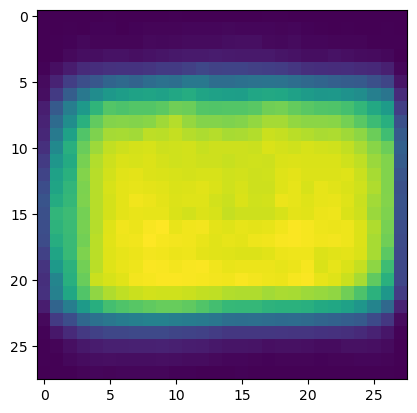

In [72]:
for iclust in range(10):
    plt.imshow(clusterer.cluster_centers_[iclust].reshape(28,28))
    plt.show()

You can see that the model is trying to assign one class to each group.

## 3. Dendograms (hierarchical clustering)

**Objective:** 

In hierarchical clustering we do not have only an optimal set of clusters, but for each different "length scale" we have a different set of clusters.

**Algorithm:** 

- We start with a length scale $l=0$ at the beginning and consider all sample elements as different clusters.

- We increase than $l$ to values larger than zero. Let's call the minimum distance between pair of points $l_0$. As soon as we reach $l=l_0$, these elements are merged into a new cluster (greedy strategy). 

To proceed further we need to define a distance between subsets $S_1,S_2$ of points. In the "single linkage" flavour we define:

$$d(S_1,S_2)=min_{a\in S_1, b\in S_2} d(a,b)$$

- This way we can proceed increasing $l>l_0$. As soon as we find two clusters with distance smaller than $l_1>l_0$, we merge them. 

- We keep on increasing $l$ as far as one one cluster remains

The result of this clustering procedure can be summarized in a `dendrogram`

In [126]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster import hierarchy
from ipywidgets import interact
from scipy.cluster.hierarchy import fcluster

points=km_load_th1()
Z = hierarchy.linkage(points, 'single')
n_clusters=int(np.max(Z[:,[0,1]].flatten()))
print(n_clusters)

@interact
def plot(t=(0,7,0.1)):  
    fig, axes=plt.subplots(1,2,figsize=(15,10), gridspec_kw={'width_ratios': [1, 2]})
    fl = fcluster(Z,t=t,criterion='distance')
    maps={}
    for clust in range(n_clusters):
        maps[clust]=(fl==clust)
    c=0
    for clust in range(n_clusters):
        if np.sum(maps[clust])>0:
            c+=1
    plt.figure(figsize=(19,5))
    d = hierarchy.dendrogram(Z,ax=axes[1], color_threshold=t)
    axes[1].axhline(t,linestyle='--',color='red')
    axes[1].set_ylabel('Cluster distance')
    axes[1].axes.get_xaxis().set_visible(False)
    axes[1].set_xlabel('Points')
    axes[1].set_title(f'Number clusters: {c}')
    axes[0].scatter(points[d['leaves'],0],points[d['leaves'],1], color=d['leaves_color_list'])


237


interactive(children=(FloatSlider(value=3.0, description='t', max=7.0), Output()), _dom_classes=('widget-inter…

**Properties:** 

If we fix a certain cutoff length $l_c$, the clusters identified $C_1,...,C_n$ at that length are such that : 

1- The constintute a disjoint partition of the whole dataset, i.e. they are mutually non intersecting aand each point belongs to a cluster 

2- The distance between two clusters $d(C_1,C_j)$ is larger than $l_c$ for each $i,j$. 


## 4. Gaussian mixtures (soft clustering)

### Theory overview.

K-Means is a modelling procedure which is biased towards clusters of circular shape and therefore does not always work perfectly, as the following examples show:

/Users/srime/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


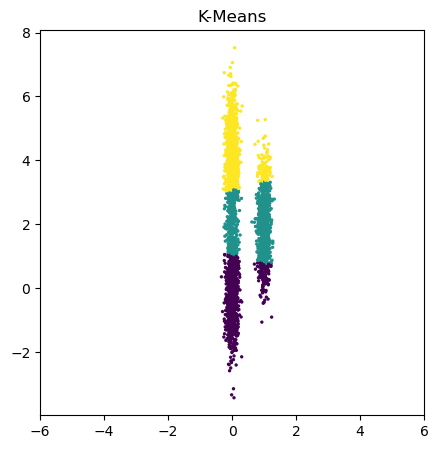

In [123]:
points=gm_load_th1()
clusterer = KMeans(n_clusters=3, random_state=10)
cluster_labels=clusterer.fit_predict(points)
plt.figure(figsize=(5,5))
plt.gca().set_aspect('equal')
plt.title('K-Means')
plt.xlim(-6,6)
plt.scatter(points[:,0],points[:,1],c=cluster_labels, s=2)
plt.show()

/Users/srime/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


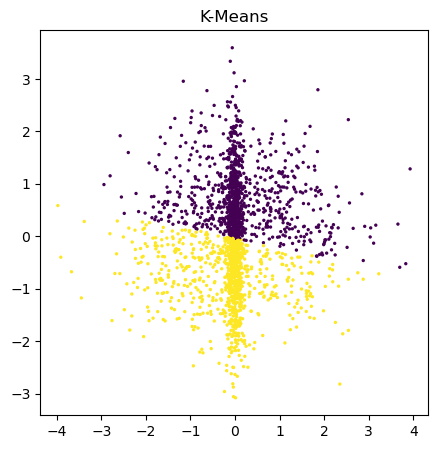

In [100]:
points=gm_load_th2()
clusterer = KMeans(n_clusters=2, random_state=10)
cluster_labels=clusterer.fit_predict(points)
plt.figure(figsize=(5,5))
plt.title('K-Means')
plt.scatter(points[:,0],points[:,1],c=cluster_labels, s=2)

A Gaussian mixture model is able to fit these kinds of clusters. In a Gaussian mixture model, each point of the distribution is supposed to be a random point from a distribution given by a superposition of Gaussians:

$$f(\mathbf{x})=\sum_c \pi_c N(\mathbf{\mu_c},\mathbf{\Sigma_c} )(\mathbf{x})$$

Each Gaussian describes the shape of each group, that may be also non spherical or tilted.

This density has the following interpretation. Suppose each data point $\hat{X}$ results from the following 2-step procedure:

1- First choose a random number between $\{1,...,N_c\}$ using some prior probabilities $\{\pi_1,...\pi_{N_c}\}$. This random variable says to what group a the point belong.

2- Now we extract the features corresponding to that point $\hat{X}$ using the corresponding density $N(\mathbf{\mu_c},\mathbf{\Sigma_c} )(\mathbf{x})$.

The parameters $\{\pi_c,\mathbf{\mu_c},\mathbf{\Sigma_c}\}$ are fitted from the data using a minimization procedure (maximum likelihood via the EM algorithm) and $N_c$ is the chosen number of clusters.



**Output of a GM computation:** 

Given the features of a new point we can reverse engineer the probability that this point was extracted one group or the other.

- *Cluster probabilities:* A gaussian mixtures model is an example of soft clustering, where each data point $p$ does not get assigned a unique cluster, but a distribution over clusters $f_p(c), c=1,...,N_c$. 

- *AIC/BIC:* after each clustering two numbers are returned. These can be used to select the optimal number of Gaussians to be used, similar to the Silhouette score. ( AIC and BIC consider both the likelihood of the data given the parameters and the complexity of the model related to the number of Gaussians used ). The lowest AIC or BIC value is an indication of a good fit.

### Sklearn: implementation and usage of Gaussian mixtures

First of all, we see how the Gaussian model behaves on our original example:

2 1592.1418091070063 1622.804218277609


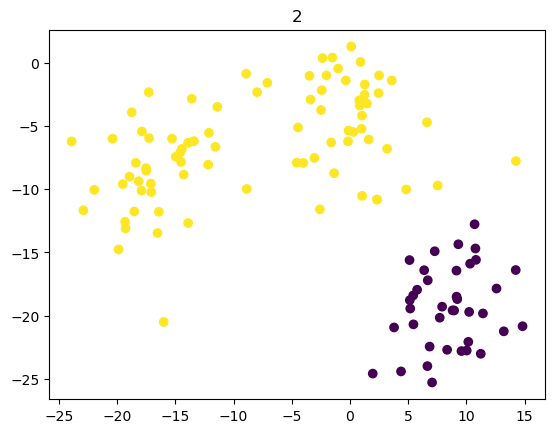

3 1550.4974051432473 1597.884764770542


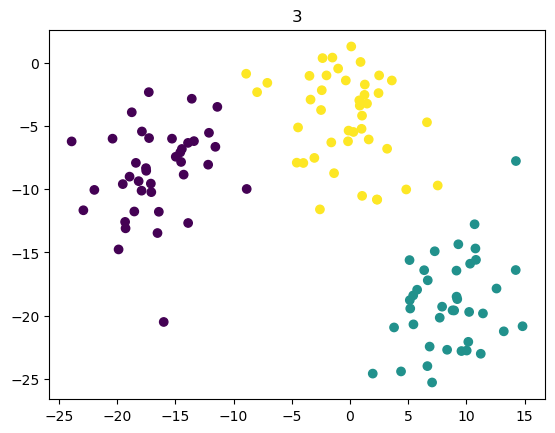

4 1560.7956890318683 1624.9079991158553


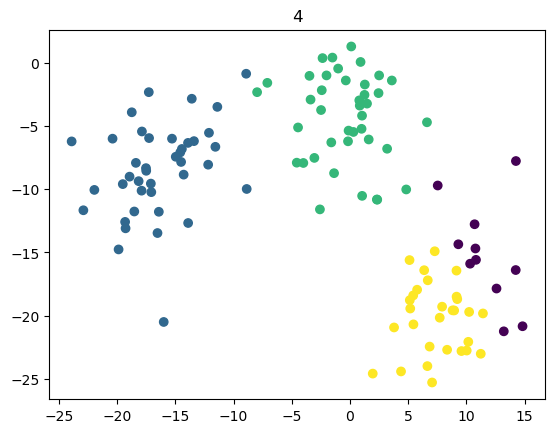

5 1566.1196297096371 1646.9568902503165


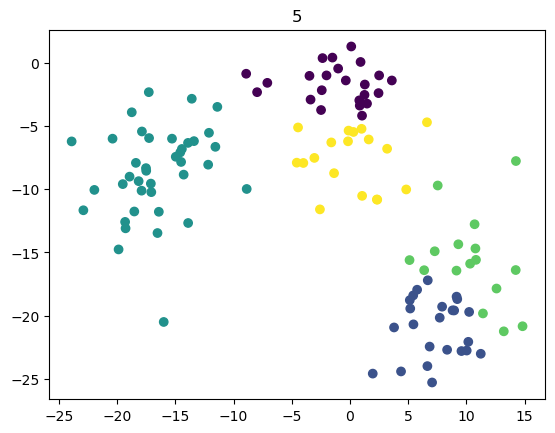

In [101]:
points=km_load_th1()

aic=[]
bic=[]
sil=[]

for i_comp in range(2,6):
    plt.figure()
    plt.title(str(i_comp))
    clf = GaussianMixture(n_components=i_comp, covariance_type='full')
    clf.fit(points)
    cluster_labels=clf.predict(points)
    plt.scatter(points[:,0],points[:,1],c=cluster_labels)
    print(i_comp,clf.aic(points),clf.bic(points))
    score=silhouette_score(points,cluster_labels)
    aic.append(clf.aic(points))
    bic.append(clf.bic(points))
    sil.append(score)
    plt.show()

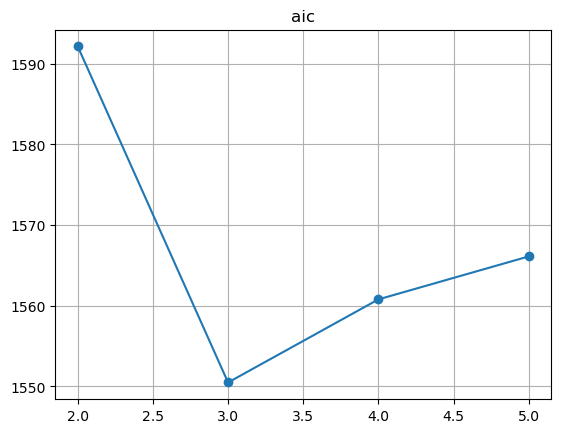

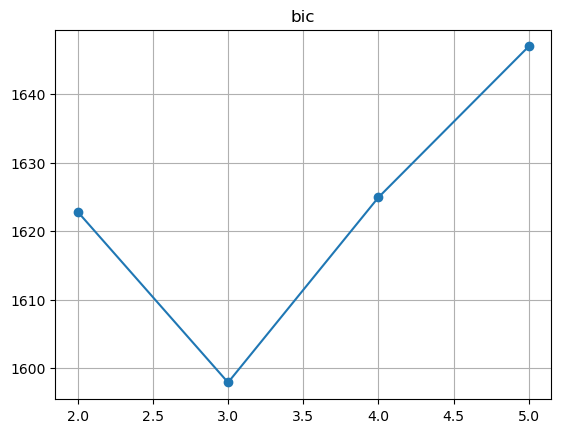

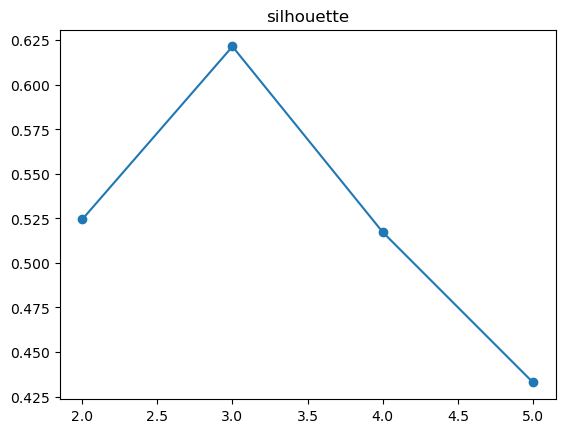

In [91]:
plt.plot(np.arange(2,6),aic,'-o')
plt.title('aic')
plt.grid()
plt.show()

plt.plot(np.arange(2,6),bic,'-o')
plt.title('bic')
plt.grid()
plt.show()

plt.plot(np.arange(2,6),sil,'-o')
plt.title('silhouette')
plt.show()

So in this case we get a comparable result, and also the probabilistic tools agree with the Silhouette score ! Let's see how the Gaussian mixtures behave in the examples where K-means was failing.

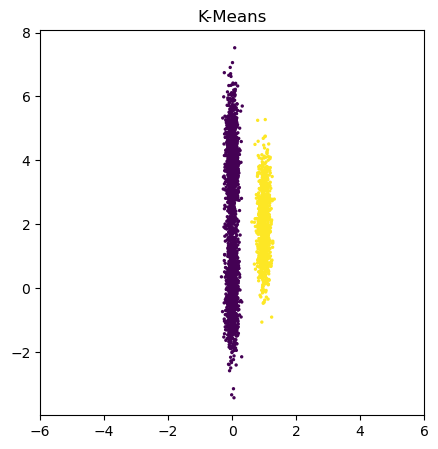

In [138]:
points=gm_load_th1()
clf = GaussianMixture(n_components=2, covariance_type='full', n_init=5, init_params='random_from_data')
clf.fit(points)
cluster_labels=clf.predict(points)
plt.figure(figsize=(5,5))
plt.gca().set_aspect('equal')
plt.title('K-Means')
plt.xlim(-6,6)
plt.scatter(points[:,0],points[:,1],c=cluster_labels, s=2)
plt.show()

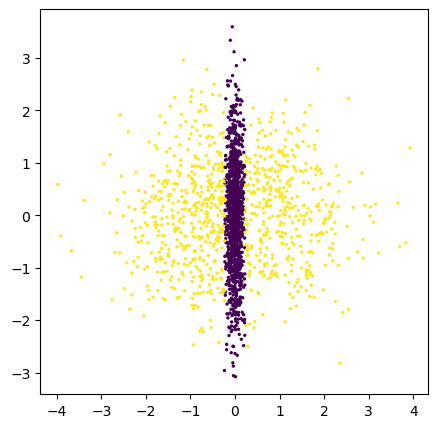

In [93]:
points=gm_load_th2()
clf = GaussianMixture(n_components=2, covariance_type='full')
clf.fit(points)
cluster_labels=clf.predict(points)
plt.figure(figsize=(5,5))
plt.scatter(points[:,0],points[:,1],c=cluster_labels, s=2)
plt.show()

# Final comments

We covered here the most basic clustering techniques, showcasing different behaviors. For real life projects, there are also other algorithms that could be taken into consideration, e.g. a popular algorithm is HDBSCAN:

- HDBSCAN : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html

whose main characteristics is that it defines automatically an optimal number of clusters. HDBSCAN can fit clusters of also weirder shapes. It is often used in combination to a non-linear dimensionality reduction methodology like UMAP.

Ultimately, the best way to measure the quality of a cluster is by visual inspecting its elements and see if they make sense domain-wise.